In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def zeta_derivs():
    """
    Gets functions evaluating derivatives of zeta
    with respect to z. Uses a linear warping of
    the z dimension to map the surface z_s to the
    midpoint of the vertical iteration space.
    
    Returns
    -------
    zeta_z : function
        Zeta with respect to z
    zeta_dz : function
        First derivative of zeta with respect to z
    inverse : function
        Z with respect to zeta
    """
    sym_names = """zeta_min, zeta_max, zeta, z_min, z_c, z"""
    zetam, zetaM, zeta, zm, zc, z = sp.symbols(sym_names)

    A = sp.Matrix([[1, zm],
                   [1, zc]])

    b = sp.Matrix([[zetam],
                   [zetaM/2]])

    sol = A**-1*b
    
    # Form the linear function
    poly = sol[0] + sol[1]*z
    print(poly)
    
    zeta_z_pars = [zetam, zetaM, zm, zc, z]
    zeta_dz_pars = [zetam, zetaM, zm, zc]  # Function parameters

    # Turn each derivative into its respective function
    zeta_z = sp.lambdify(zeta_z_pars, poly)
    zeta_dz = sp.lambdify(zeta_dz_pars, sp.diff(poly, z, 1))

    # Calculate the inverse mapping zeta onto z
    inv_pars = [zetam, zetaM, zm, zc, zeta]
    inverse = sp.lambdify(inv_pars, sp.solve(poly - zeta, z)[0])

    return zeta_z, zeta_dz, inverse


def z_s(x, h, x_M, x_m, z_M, z_m):
    """
    Z position of cosine hill of height h, with a
    baseline at (z_M+z_m)/2.
    
    Parameters
    ----------
    x : float or ndarray
        X position to calculate z value for
    h : float
        Maximum height of the hill above the
        baseline.
    x_M : float
        Maximum value of x
    x_m : float
        Minimum value of x
    z_M : float
        Maximum value of z
    z_m : float
        Minimum value of z
    """
    baseline = (z_M+z_m)/2
    cos_centre = baseline + h/2
    w = x_M-x_m
    z = cos_centre - h*np.cos(2*np.pi*(x-x_m)/w)/2
    return z

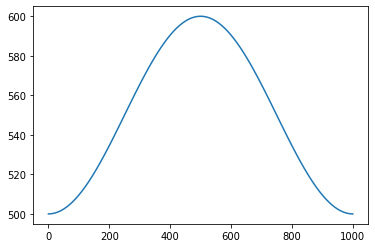

z*(zeta_max/(2*(z_c - z_min)) - zeta_min/(z_c - z_min)) + z_c*zeta_min/(z_c - z_min) - z_min*zeta_max/(2*(z_c - z_min))


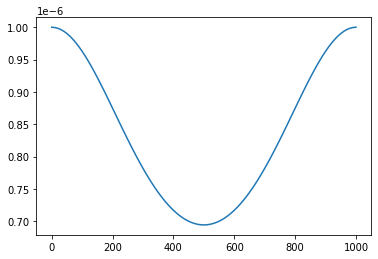

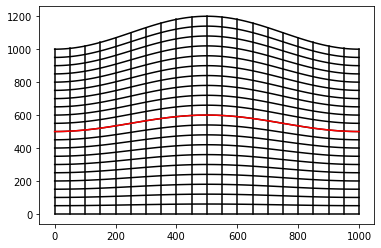

In [2]:
from devito import SpaceDimension, Grid, Function

# Grid parameterisation
x_m = 0
x_M = 1000  # Units of metres
z_m = 0
z_M = 1000
zeta_m = 0
zeta_M = 1

h = 100  # Height of topography

x = SpaceDimension(name='x')
zeta = SpaceDimension(name='zeta')

grid = Grid(shape=(101, 101), extent=(x_M-x_m, zeta_M-zeta_m),
            origin=(x_m, zeta_m), dimensions=(x, zeta))

# Get surface profile
x_vals = np.linspace(x_m, x_M, grid.shape[0])
zeta_vals = np.linspace(zeta_m, zeta_M, grid.shape[1])
surface_z = z_s(x_vals, h, x_M, x_m, z_M, z_m)
# Test making surface flat -> should result in normal mapping
# surface_z = np.full(grid.shape[0], 500)
plt.plot(x_vals, surface_z)
plt.show()

# Derivatives of zeta can be precalculated
zeta_dz = Function(name='zeta_dz', shape=(grid.shape[0],),
                   extent=(grid.extent[0],), origin=(x_m,),
                   dimensions=(x,))
# Second derivative is zero as mapping is linear
_, zet_d1, z = zeta_derivs()

zeta_dz.data[:] = zet_d1(zeta_m, zeta_M, z_m, surface_z)
plt.plot(x_vals, zeta_dz.data**2)
plt.show()

# Make an x-zeta meshgrid
x_msh, zeta_msh = np.meshgrid(x_vals, zeta_vals)

z_msh = z(zeta_m, zeta_M, z_m, surface_z, zeta_msh)

# Make a plot showing zeta horizons in x-z space
cells = 20
# Plot the x lines
plt.plot(x_msh[:, ::grid.shape[0]//cells], z_msh[:, ::grid.shape[1]//cells], 'k')
# Plot the zeta horizons
plt.plot(x_msh.T[:, ::grid.shape[0]//cells], z_msh.T[:, ::grid.shape[1]//cells], 'k')
# Pick out the central horizon
plt.plot(x_vals, z(zeta_m, zeta_M, z_m, surface_z, (zeta_M-zeta_m)/2), 'r')
plt.show()

In [3]:
from devito import TimeFunction, Eq

# Wavespeed
c = 2

# Set up the function and equations
p = TimeFunction(name="p", grid=grid, time_order=2, space_order=8)
eq = Eq(p.forward, 2*p - p.backward + c**2*(p.dx2 + p.dzeta2*zeta_dz**2))

In [4]:
# Create the free surface
def freesurface(f):
    """
    Implements an acoustic free-surface boundary at
    the centre index.
    
    Parameters
    ----------
    f : TimeFunction
        The function on which the boundary condition
        is imposed.
    """
    t = grid.stepping_dim
    
    # Midpoint index
    mid_ind = (f.grid.shape[1]-1)//2
    bcs = [Eq(f[t+1,x, mid_ind], 0)]
    for i in range(f.space_order//2):
        bcs += [Eq(f[t+1,x, mid_ind+i+1], -f[t+1,x, mid_ind-i-1])]
    return bcs


bcs = freesurface(p)

In [5]:
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts a t=0
tn = 500.  # Simulation last 1 second (1000 ms)
dt = grid.extent[0]/(2*c*(grid.shape[0]-1))  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(grid.extent)/2  # Centre first
src.coordinates.data[0, -1] = grid.extent[1]/3  # Set depth

src_term = src.inject(field=p.forward, expr=src*dt**2/c)

In [6]:
from devito import Operator

op = Operator([eq] + bcs + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.011201999999999991, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=9e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

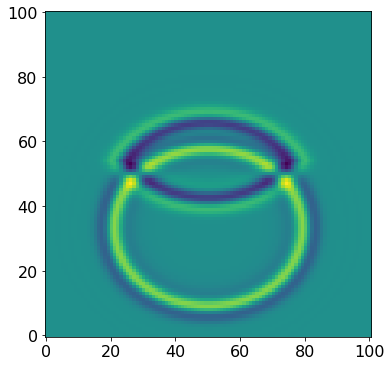

In [7]:
plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.imshow(p.data[-1].T, origin='lower')
plt.show()

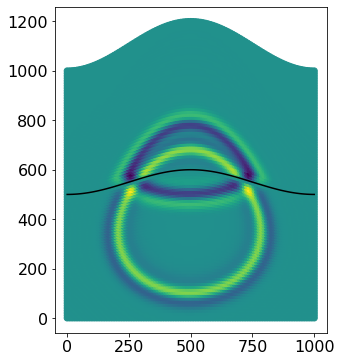

In [8]:
plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(x_msh, z_msh, c=p.data[-1].T, cmap='viridis')
# Pick out the central horizon
plt.plot(x_vals, z(zeta_m, zeta_M, z_m, surface_z, (zeta_M-zeta_m)/2), 'k')
plt.show()

In [9]:
# Source injection is round in transformed space
# Needs to be round in real space
# Maybe something to do with seismic velocity?

# Reflection geometry looks good though

#Orrr have I done something dumb with my transforms?